# CSCA 5622 Supervised Learning Final Project

**Course Number:** CSCA 5622  
**Semester:** Summer 2, 2024  
**Student Name:** Yuning Mu

### 1. **Project Overview**
**Topics and Goals**
   - **Project Topic:** 
     - This project will focus on predicting student performance based on various attributes such as demographic data, family background, and school-related factors.
     - **Type of Learning:** Supervised learning.
     - **Type of Task:** Classification task (predicting whether a student passes or fails).
   - **Goal:** 
     - The goal of the project is to build a model that can predict student performance to help educators identify students at risk of underperforming and provide timely interventions.

**Dataset Description**
  - **Data Source:** 
    - The dataset `student-mat.csv` is derived from a public dataset available on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Student+Performance), specifically in the subject of Mathematics.
  - **Description:** 
    - The dataset includes 396 student records with 30 features related to student achievement in secondary education, which include demographic, social, and school-related features, as well as student grades. The data was collected from two Portuguese schools using school reports and questionnaires.
  - **Data Characteristics:** 
    - **Type:** Multivariate
    - **Subject Area:** Social Science
    - **Associated Tasks:** Classification

Importing necessary libraries:

In [78]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from textwrap import wrap

The following code snippet reads the dataset `student-mat.csv` and prints the first few rows to give an overview of the data structure.

The data contains 395 rows and 33 columns in total.

In [79]:
data = pd.read_csv('grade_data/student-mat.csv')

print(data.head())

print("Rows:    ", data.shape[0])
print("Columns: ", data.shape[1])

  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]
Rows:     395
Columns:  33


The file `grade_data/mapping.py` maps the feature names in the dataset to their actual meanings, making it easier to interpret and understand future visualizations. Below is a sample structure of the mapping:

In [80]:
from grade_data.mapping import get_mapping

feature_mapping = get_mapping()
SAMPLE_SIZE = 3
# Now you can use the feature_mapping dictionary
for i, (key, value) in enumerate(feature_mapping.items()):
    print(f"{key}:")
    for k,v in value.items():
        print(f"    {k}: {v}")
    if i + 1 == SAMPLE_SIZE:
        break
print("... and more")

school:
    name: School
    description: Student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)
    type: Categorical
    demographic: None
sex:
    name: Sex
    description: Student's sex (binary: 'F' - female or 'M' - male)
    type: Binary
    demographic: Sex
age:
    name: Age
    description: Student's age (numeric: from 15 to 22)
    type: Integer
    demographic: Age
... and more


### 2. **Exploratory Data Analysis (EDA) and Data Cleaning**

#### a. EDA
We can proceed with Exploratory Data Analysis (EDA). We will explore the data visually to understand the distribution of features, correlations between them, and the relationship between features and the target variable.

**Checking for Missing or NaN Values**

First, it's essential check if the dataset contains any missing or NaN values. Missing values can affect the performance of algorithms and might need to be handled appropriately. The following code checks for missing values in each column of the dataset.
There are no missing values or NaN values in the dataset.


In [81]:
missing_values = data.isnull().sum()

print("Are there missing values in any column?")
if missing_values.any():
    print("The following columns have missing values:")
    for column, value in missing_values[missing_values > 0].items():
        print(f"- {column}: {value} missing value(s)")
else:
    print("No missing values found")

print("\nAre there any NaN values in the dataset?")
if data.isnull().values.any():
    nan_columns = data.columns[data.isnull().any()]
    print(f"Yes, there are NaN values in the following columns: {list(nan_columns)}")
else:
    print("No, there are no NaN values in the dataset.")

Are there missing values in any column?
No missing values found

Are there any NaN values in the dataset?
No, there are no NaN values in the dataset.


**Checking for Duplicate Rows**

Next, we check for duplicate rows in the dataset. Duplicates can cause bias in the analysis and need to be addressed. The code checks for the number of duplicate rows, and if any are found, it removes them and provides the count of rows before and after the removal.


In [82]:
duplicates = data.duplicated().sum()
print(f"\nNumber of duplicate rows in the dataset: {duplicates}")

if duplicates > 0:
    data_cleaned = data.drop_duplicates()
    print(f"Number of rows after removing duplicates: {data_cleaned.shape[0]}")
else:
    print("No duplicates found.")


Number of duplicate rows in the dataset: 0
No duplicates found.


**Feature Distribution Analysis**

Understanding the distribution of each feature is crucial in data analysis, as it helps to identify patterns, outliers, and the overall spread of the data. In this section, we will plot the distribution of each feature in the dataset. For numerical features, we will use histograms, and for categorical features, we will use bar plots.


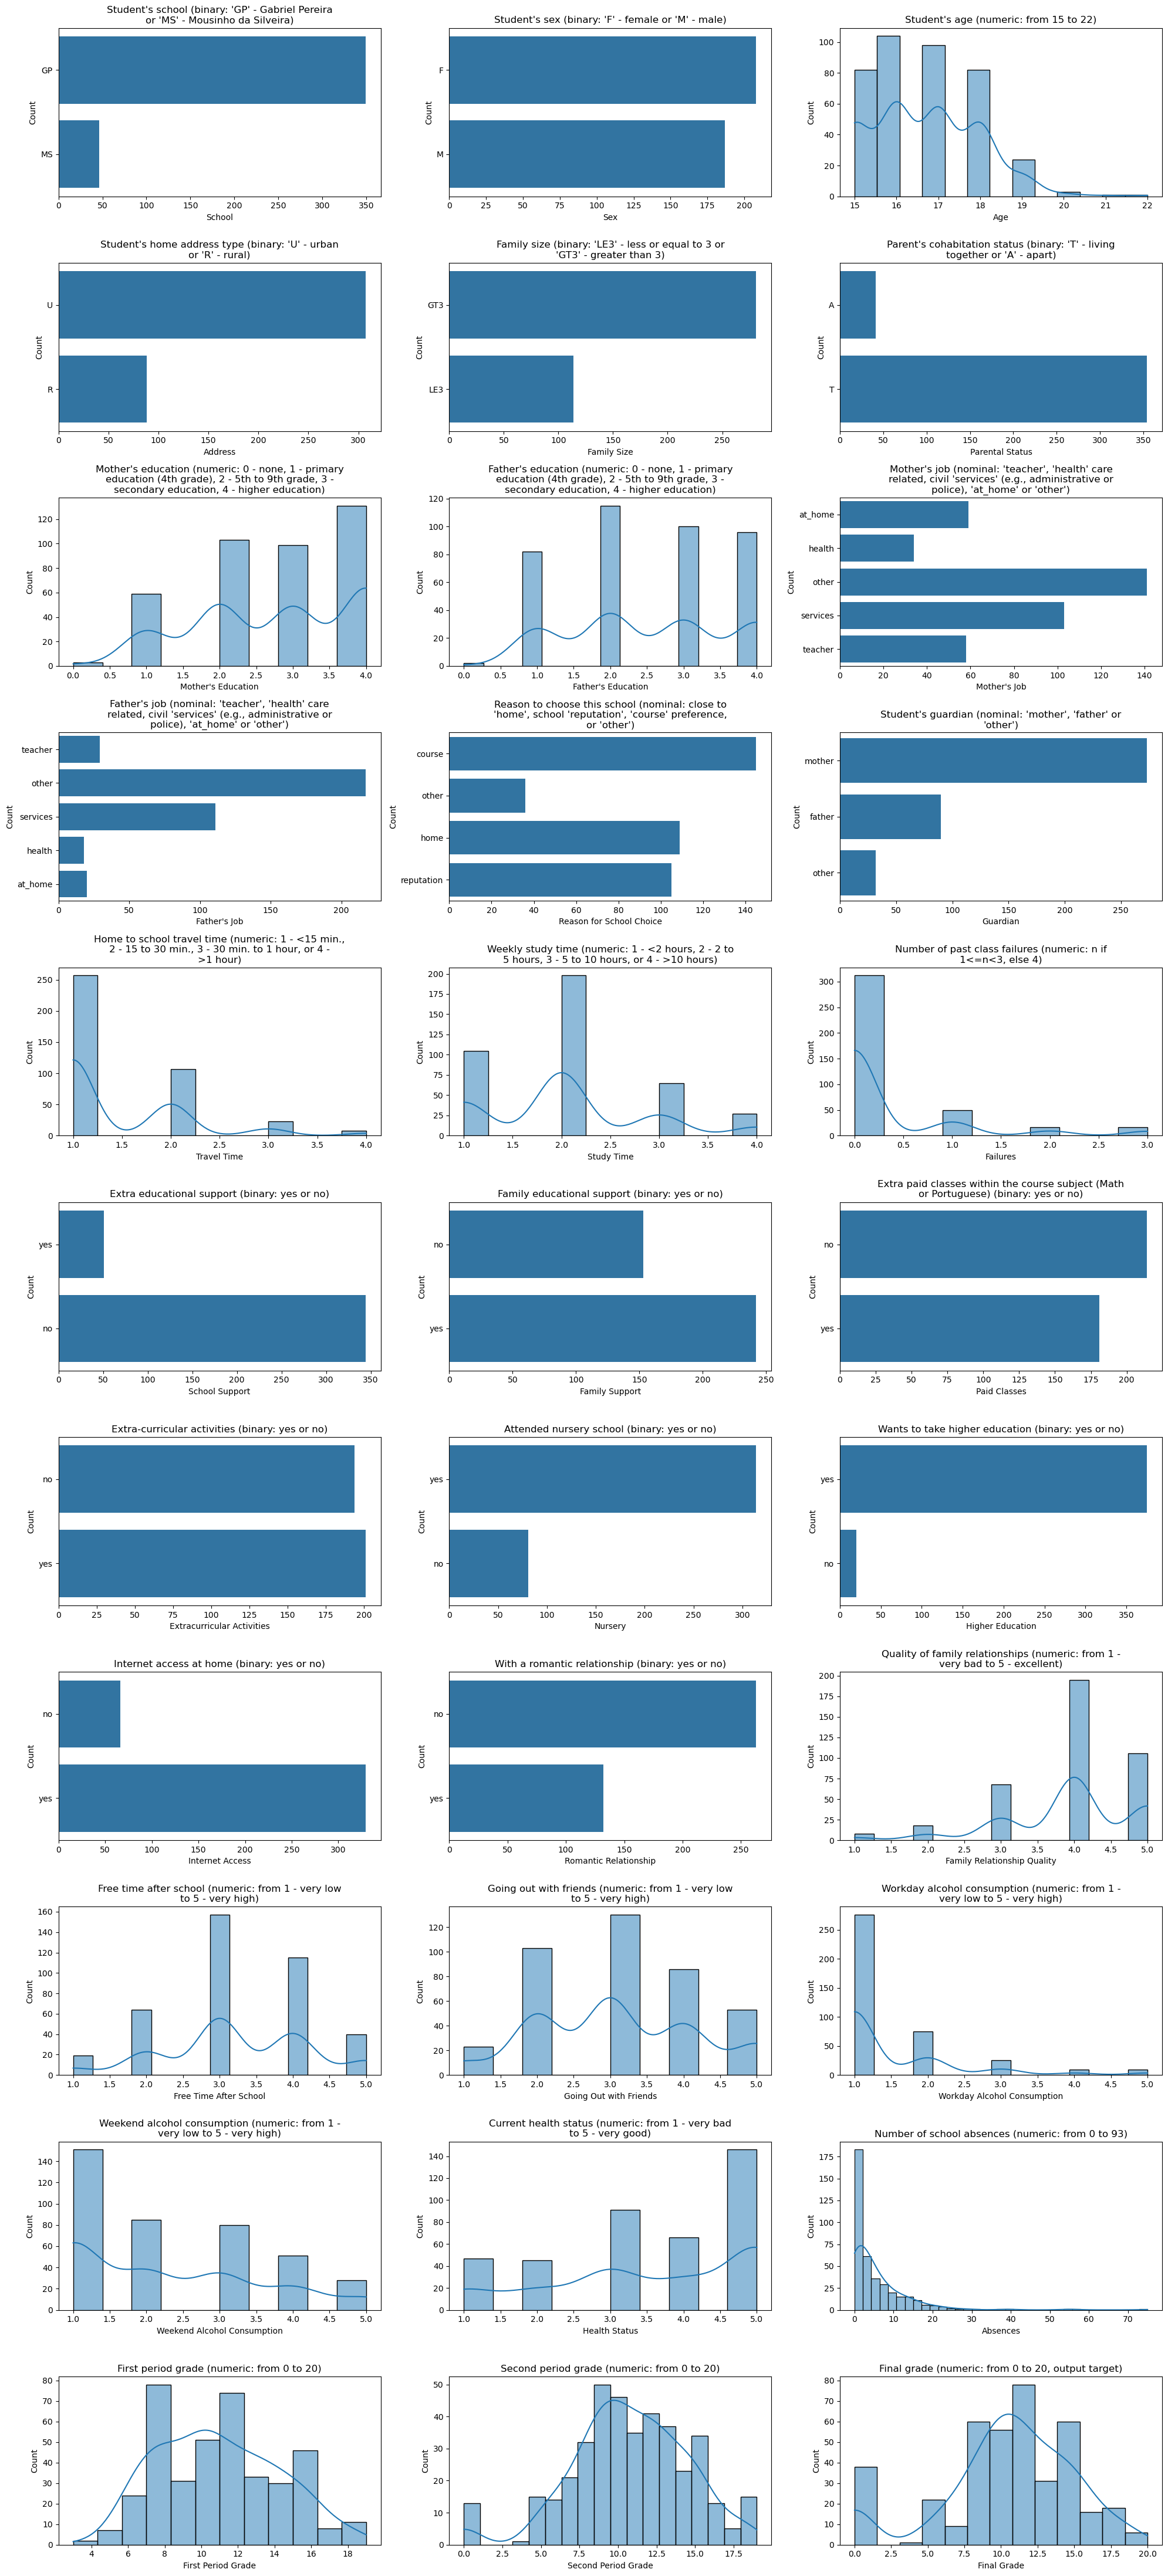

In [85]:
def plot_feature_distribution(data, feature_mapping, items_per_row=3):
    num_features = len(data.columns)
    num_rows = (num_features + items_per_row - 1) // items_per_row

    fig, axes = plt.subplots(nrows=num_rows, ncols=items_per_row, figsize=(20, num_rows * 4))
    axes = axes.flatten()

    for i, column in enumerate(data.columns):
        # Get the feature mapping details
        mapping = feature_mapping.get(column, {})
        title = mapping.get("name", column)
        description = mapping.get("description", "No description")
        feature_type = mapping.get("type", "Unknown type")
        
        # Plot based on feature type
        if feature_type == "Binary" or feature_type == "Categorical":
            sns.countplot(data[column], ax=axes[i])
        else:
            sns.histplot(data[column], kde=True, ax=axes[i])
        
        # Set title with mapping info
        axes[i].set_title("\n".join(wrap(description, 50)))
        axes[i].set_xlabel(title)
        axes[i].set_ylabel('Count')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the combined figure
    plt.show()

# Call the function to plot all features with integrated mapping info
plot_feature_distribution(data, feature_mapping)